##### Copyright 2023 Google LLC

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Setup

In [1]:
!pip install -U -q "google-generativeai>=0.8.2"

In [ ]:
# import necessary modules.
import base64
import copy
import json
import pathlib
import requests


import PIL.Image
import IPython.display
from IPython.display import Markdown

try:
    # The SDK will automatically read it from the GOOGLE_API_KEY environment variable.
    # In Colab get the key from Colab-secrets ("🔑" in the left panel).
    import os
    from google.colab import userdata

    os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")
except ImportError:
    pass

import google.generativeai as genai

# Parse the arguments

model = 'gemini-2.0-flash-exp' # @param {isTemplate: true}
contents_b64 = 'W3sicGFydHMiOlt7InRleHQiOiJpbXBvcnQgdG9yY2hcXG5pbXBvcnQgdG9yY2gubm4gYXMgbm5cXG5pbXBvcnQgdG9yY2gub3B0aW0gYXMgb3B0aW1cXG5mcm9tIHRvcmNodmlzaW9uIGltcG9ydCBkYXRhc2V0cywgdHJhbnNmb3Jtc1xcbmZyb20gdG9yY2gudXRpbHMuZGF0YSBpbXBvcnQgRGF0YUxvYWRlclxcbmZyb20gc2tsZWFybi5tZXRyaWNzIGltcG9ydCBjbGFzc2lmaWNhdGlvbl9yZXBvcnRcXG5pbXBvcnQgbWF0cGxvdGxpYi5weXBsb3QgYXMgcGx0XFxuXFxuIyBEZXZpY2UgY29uZmlndXJhdGlvblxcbmRldmljZSA9IHRvcmNoLmRldmljZSgnY3VkYScgaWYgdG9yY2guY3VkYS5pc19hdmFpbGFibGUoKSBlbHNlICdjcHUnKVxcblxcbiMgSHlwZXJwYXJhbWV0ZXJzXFxubnVtX2Vwb2NocyA9IDNcXG5iYXRjaF9zaXplID0gNjRcXG5sZWFybmluZ19yYXRlID0gMC4wMVxcblxcbiMgRGF0YSBhdWdtZW50YXRpb24gYW5kIG5vcm1hbGl6YXRpb25cXG50cmFuc2Zvcm0gPSB0cmFuc2Zvcm1zLkNvbXBvc2UoW1xcbiAgICB0cmFuc2Zvcm1zLlJhbmRvbUhvcml6b250YWxGbGlwKCksXFxuICAgIHRyYW5zZm9ybXMuUmFuZG9tUm90YXRpb24oMTApLFxcbiAgICB0cmFuc2Zvcm1zLlRvVGVuc29yKCksXFxuICAgIHRyYW5zZm9ybXMuTm9ybWFsaXplKCgwLjUsKSwgKDAuNSwpKSAgIyBOb3JtYWxpemUgdG8gWy0xLCAxXVxcbl0pXFxuXFxuIyBMb2FkIHRoZSBGYXNoaW9uLU1OSVNUIERhdGFzZXRcXG50cmFpbl9kYXRhc2V0ID0gZGF0YXNldHMuRmFzaGlvbk1OSVNUKHJvb3Q9Jy4vZGF0YScsXFxuICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICB0cmFpbj1UcnVlLFxcbiAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgdHJhbnNmb3JtPXRyYW5zZm9ybSxcXG4gICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgIGRvd25sb2FkPVRydWUpXFxuXFxudGVzdF9kYXRhc2V0ID0gZGF0YXNldHMuRmFzaGlvbk1OSVNUKHJvb3Q9Jy4vZGF0YScsXFxuICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgIHRyYWluPUZhbHNlLFxcbiAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICB0cmFuc2Zvcm09dHJhbnNmb3Jtcy5Db21wb3NlKFtcXG4gICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgIHRyYW5zZm9ybXMuVG9UZW5zb3IoKSxcXG4gICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgIHRyYW5zZm9ybXMuTm9ybWFsaXplKCgwLjUsKSwgKDAuNSwpKVxcbiAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICBdKSxcXG4gICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgZG93bmxvYWQ9VHJ1ZSlcXG5cXG4jIERhdGEgbG9hZGVyc1xcbnRyYWluX2xvYWRlciA9IERhdGFMb2FkZXIoZGF0YXNldD10cmFpbl9kYXRhc2V0LFxcbiAgICAgICAgICAgICAgICAgICAgICAgICAgYmF0Y2hfc2l6ZT1iYXRjaF9zaXplLFxcbiAgICAgICAgICAgICAgICAgICAgICAgICAgc2h1ZmZsZT1UcnVlKVxcblxcbnRlc3RfbG9hZGVyID0gRGF0YUxvYWRlcihkYXRhc2V0PXRlc3RfZGF0YXNldCxcXG4gICAgICAgICAgICAgICAgICAgICAgICAgYmF0Y2hfc2l6ZT1iYXRjaF9zaXplLFxcbiAgICAgICAgICAgICAgICAgICAgICAgICBzaHVmZmxlPUZhbHNlKVxcblxcbiMgRGVmaW5lIHRoZSBDTk4gTW9kZWxcXG5jbGFzcyBDTk5Nb2RlbChubi5Nb2R1bGUpOlxcbiAgICBkZWYgX19pbml0X18oc2VsZik6XFxuICAgICAgICBzdXBlcihDTk5Nb2RlbCwgc2VsZikuX19pbml0X18oKVxcbiAgICAgICAgc2VsZi5jb252MSA9IG5uLkNvbnYyZCgxLCA4LCA1KVxcbiAgICAgICAgc2VsZi5ibjEgPSBubi5CYXRjaE5vcm0yZCg4KSAgIyBCYXRjaCBOb3JtYWxpemF0aW9uXFxuICAgICAgICBzZWxmLnBvb2wgPSBubi5NYXhQb29sMmQoMiwgMilcXG4gICAgICAgIHNlbGYuY29udjIgPSBubi5Db252MmQoOCwgMTYsIDUpXFxuICAgICAgICBzZWxmLmJuMiA9IG5uLkJhdGNoTm9ybTJkKDE2KSAgIyBCYXRjaCBOb3JtYWxpemF0aW9uXFxuICAgICAgICBzZWxmLmRyb3BvdXQgPSBubi5Ecm9wb3V0KDAuMjUpICAjIERyb3BvdXQgbGF5ZXJcXG4gICAgICAgIHNlbGYuZmMxID0gbm4uTGluZWFyKDE2ICogNCAqIDQsIDEyMClcXG4gICAgICAgIHNlbGYuZmMyID0gbm4uTGluZWFyKDEyMCwgODQpXFxuICAgICAgICBzZWxmLmZjMyA9IG5uLkxpbmVhcig4NCwgMTApXFxuXFxuICAgIGRlZiBmb3J3YXJkKHNlbGYsIHgpOlxcbiAgICAgICAgeCA9IHNlbGYucG9vbChGLnJlbHUoc2VsZi5ibjEoc2VsZi5jb252MSh4KSkpKVxcbiAgICAgICAgeCA9IHNlbGYucG9vbChGLnJlbHUoc2VsZi5ibjIoc2VsZi5jb252Mih4KSkpKVxcbiAgICAgICAgeCA9IHgudmlldygtMSwgMTYgKiA0ICogNClcXG4gICAgICAgIHggPSBGLnJlbHUoc2VsZi5mYzEoeCkpXFxuICAgICAgICB4ID0gc2VsZi5kcm9wb3V0KHgpICAjIEFwcGx5IGRyb3BvdXRcXG4gICAgICAgIHggPSBGLnJlbHUoc2VsZi5mYzIoeCkpXFxuICAgICAgICB4ID0gc2VsZi5mYzMoeClcXG4gICAgICAgIHJldHVybiB4XFxuXFxuIyBJbml0aWFsaXplIHRoZSBtb2RlbCwgbG9zcyBmdW5jdGlvbiwgYW5kIG9wdGltaXplclxcbm1vZGVsID0gQ05OTW9kZWwoKS50byhkZXZpY2UpXFxuY3JpdGVyaW9uID0gbm4uQ3Jvc3NFbnRyb3B5TG9zcygpXFxub3B0aW1pemVyID0gb3B0aW0uQWRhbShtb2RlbC5wYXJhbWV0ZXJzKCksIGxyPWxlYXJuaW5nX3JhdGUpXFxuc2NoZWR1bGVyID0gb3B0aW0ubHJfc2NoZWR1bGVyLlN0ZXBMUihvcHRpbWl6ZXIsIHN0ZXBfc2l6ZT0xLCBnYW1tYT0wLjcpXFxuXFxuIyBUcmFpbmluZyBmdW5jdGlvblxcbmRlZiB0cmFpbihtb2RlbCwgZGV2aWNlLCB0cmFpbl9sb2FkZXIsIG9wdGltaXplciwgY3JpdGVyaW9uKTpcXG4gICAgbW9kZWwudHJhaW4oKVxcbiAgICBlcG9jaF9sb3NzID0gMFxcbiAgICBmb3IgYmF0Y2hfaWR4LCAoZGF0YSwgdGFyZ2V0KSBpbiBlbnVtZXJhdGUodHJhaW5fbG9hZGVyKTpcXG4gICAgICAgIGRhdGEsIHRhcmdldCA9IGRhdGEudG8oZGV2aWNlKSwgdGFyZ2V0LnRvKGRldmljZSlcXG4gICAgICAgIG9wdGltaXplci56ZXJvX2dyYWQoKVxcbiAgICAgICAgb3V0cHV0ID0gbW9kZWwoZGF0YSlcXG4gICAgICAgIGxvc3MgPSBjcml0ZXJpb24ob3V0cHV0LCB0YXJnZXQpXFxuICAgICAgICBsb3NzLmJhY2t3YXJkKClcXG4gICAgICAgIG9wdGltaXplci5zdGVwKClcXG4gICAgICAgIGVwb2NoX2xvc3MgKz0gbG9zcy5pdGVtKClcXG4gICAgcmV0dXJuIGVwb2NoX2xvc3MgLyBsZW4odHJhaW5fbG9hZGVyKVxcblxcbiMgVGVzdGluZyBmdW5jdGlvblxcbmRlZiB0ZXN0KG1vZGVsLCBkZXZpY2UsIHRlc3RfbG9hZGVyLCBjcml0ZXJpb24pOlxcbiAgICBtb2RlbC5ldmFsKClcXG4gICAgdGVzdF9sb3NzID0gMFxcbiAgICBjb3JyZWN0ID0gMFxcbiAgICBhbGxfcHJlZHMgPSBbXVxcbiAgICBhbGxfdGFyZ2V0cyA9IFtdXFxuICAgIHdpdGggdG9yY2gubm9fZ3JhZCgpOlxcbiAgICAgICAgZm9yIGRhdGEsIHRhcmdldCBpbiB0ZXN0X2xvYWRlcjpcXG4gICAgICAgICAgICBkYXRhLCB0YXJnZXQgPSBkYXRhLnRvKGRldmljZSksIHRhcmdldC50byhkZXZpY2UpXFxuICAgICAgICAgICAgb3V0cHV0ID0gbW9kZWwoZGF0YSlcXG4gICAgICAgICAgICB0ZXN0X2xvc3MgKz0gY3JpdGVyaW9uKG91dHB1dCwgdGFyZ2V0KS5pdGVtKCkgKiBkYXRhLnNpemUoMClcXG4gICAgICAgICAgICBwcmVkID0gb3V0cHV0LmFyZ21heChkaW09MSwga2VlcGRpbT1UcnVlKVxcbiAgICAgICAgICAgIGNvcnJlY3QgKz0gcHJlZC5lcSh0YXJnZXQudmlld19hcyhwcmVkKSkuc3VtKCkuaXRlbSgpXFxuICAgICAgICAgICAgYWxsX3ByZWRzLmV4dGVuZChwcmVkLmNwdSgpLm51bXB5KCkpXFxuICAgICAgICAgICAgYWxsX3RhcmdldHMuZXh0ZW5kKHRhcmdldC5jcHUoKS5udW1weSgpKVxcblxcbiAgICB0ZXN0X2xvc3MgLz0gbGVuKHRlc3RfbG9hZGVyLmRhdGFzZXQpXFxuICAgIGFjY3VyYWN5ID0gMTAwLiAqIGNvcnJlY3QgLyBsZW4odGVzdF9sb2FkZXIuZGF0YXNldClcXG4gICAgcHJpbnQoZidcXFxcblRlc3Qgc2V0OiBBdmVyYWdlIGxvc3M6IHt0ZXN0X2xvc3M6LjRmfSwgQWNjdXJhY3k6IHtjb3JyZWN0fS97bGVuKHRlc3RfbG9hZGVyLmRhdGFzZXQpfSAoe2FjY3VyYWN5Oi4wZn0lKVxcXFxuJylcXG5cXG4gICAgcmV0dXJuIHRlc3RfbG9zcywgYWNjdXJhY3ksIGFsbF9wcmVkcywgYWxsX3RhcmdldHNcXG5cXG4jIFRyYWluaW5nIGxvb3Agd2l0aCB2aXN1YWxpemF0aW9uXFxudHJhaW5fbG9zc2VzID0gW11cXG50ZXN0X2xvc3NlcyA9IFtdXFxuYWNjdXJhY2llcyA9IFtdXFxuXFxuZm9yIGVwb2NoIGluIHJhbmdlKDEsIG51bV9lcG9jaHMgKyAxKTpcXG4gICAgcHJpbnQoZlxcXCJFcG9jaCB7ZXBvY2h9L3tudW1fZXBvY2hzfVxcXCIpXFxuICAgIHRyYWluX2xvc3MgPSB0cmFpbihtb2RlbCwgZGV2aWNlLCB0cmFpbl9sb2FkZXIsIG9wdGltaXplciwgY3JpdGVyaW9uKVxcbiAgICB0ZXN0X2xvc3MsIGFjY3VyYWN5LCBhbGxfcHJlZHMsIGFsbF90YXJnZXRzID0gdGVzdChtb2RlbCwgZGV2aWNlLCB0ZXN0X2xvYWRlciwgY3JpdGVyaW9uKVxcbiAgICB0cmFpbl9sb3NzZXMuYXBwZW5kKHRyYWluX2xvc3MpXFxuICAgIHRlc3RfbG9zc2VzLmFwcGVuZCh0ZXN0X2xvc3MpXFxuICAgIGFjY3VyYWNpZXMuYXBwZW5kKGFjY3VyYWN5KVxcbiAgICBzY2hlZHVsZXIuc3RlcCgpXFxuXFxuIyBDbGFzc2lmaWNhdGlvbiByZXBvcnRcXG5wcmludChcXFwiXFxcXG5DbGFzc2lmaWNhdGlvbiBSZXBvcnQ6XFxcIilcXG5wcmludChjbGFzc2lmaWNhdGlvbl9yZXBvcnQoYWxsX3RhcmdldHMsIGFsbF9wcmVkcywgdGFyZ2V0X25hbWVzPXRyYWluX2RhdGFzZXQuY2xhc3NlcykpXFxuXFxuIyBQbG90IHRyYWluaW5nIGxvc3NcXG5wbHQuZmlndXJlKGZpZ3NpemU9KDEwLCA1KSlcXG5wbHQucGxvdCh0cmFpbl9sb3NzZXMsIGxhYmVsPSdUcmFpbmluZyBMb3NzJylcXG5wbHQucGxvdCh0ZXN0X2xvc3NlcywgbGFiZWw9J1Rlc3QgTG9zcycpXFxucGx0LnhsYWJlbCgnRXBvY2hzJylcXG5wbHQueWxhYmVsKCdMb3NzJylcXG5wbHQudGl0bGUoJ1RyYWluaW5nIGFuZCBUZXN0IExvc3MnKVxcbnBsdC5sZWdlbmQoKVxcbnBsdC5zaG93KClcXG5cXG4jIFNhdmUgdGhlIG1vZGVsXFxudG9yY2guc2F2ZShtb2RlbCwgJ2Zhc2hpb25fbW5pc3RfY25uX2Z1bGwucHRoJylcXG5wcmludChcXFwiTW9kZWwgc2F2ZWQgYXMgJ2Zhc2hpb25fbW5pc3RfY25uX2Z1bGwucHRoJy5cXFwiKSJ9LHsidGV4dCI6ImlucHV0OiAifSx7InRleHQiOiJvdXRwdXQ6ICJ9XX1d' # @param {isTemplate: true}
generation_config_b64 = 'eyJ0ZW1wZXJhdHVyZSI6MSwidG9wX3AiOjAuOTUsInRvcF9rIjo0MCwibWF4X291dHB1dF90b2tlbnMiOjgxOTJ9' # @param {isTemplate: true}
safety_settings_b64 = "e30="  # @param {isTemplate: true}

gais_contents = json.loads(base64.b64decode(contents_b64))

generation_config = json.loads(base64.b64decode(generation_config_b64))
safety_settings = json.loads(base64.b64decode(safety_settings_b64))

stream = False

# Convert and upload the files

tempfiles = pathlib.Path(f"tempfiles")
tempfiles.mkdir(parents=True, exist_ok=True)


drive = None
def upload_file_data(file_data, index):
    """Upload files to the Files API.

    For each file, Google AI Studio either sent:
    - a Google Drive ID,
    - a URL,
    - a file path, or
    - The raw bytes (`inline_data`).

    The API only understands `inline_data` or it's Files API.
    This code, uploads files to the files API where the API can access them.
    """

    mime_type = file_data["mime_type"]
    if drive_id := file_data.pop("drive_id", None):
        if drive is None:
          from google.colab import drive
          drive.mount("/gdrive")

        path = next(
            pathlib.Path(f"/gdrive/.shortcut-targets-by-id/{drive_id}").glob("*")
        )
        print("Uploading:", str(path))
        file_info = genai.upload_file(path=path, mime_type=mime_type)
        file_data["file_uri"] = file_info.uri
        return

    if url := file_data.pop("url", None):
        response = requests.get(url)
        data = response.content
        name = url.split("/")[-1]
        path = tempfiles / str(index)
        path.write_bytes(data)
        print("Uploading:", url)
        file_info = genai.upload_file(path, display_name=name, mime_type=mime_type)
        file_data["file_uri"] = file_info.uri
        return

    if name := file_data.get("filename", None):
        if not pathlib.Path(name).exists():
            raise IOError(
                f"local file: `{name}` does not exist. You can upload files "
                'to Colab using the file manager ("📁 Files" in the left '
                "toolbar)"
            )
        file_info = genai.upload_file(path, display_name=name, mime_type=mime_type)
        file_data["file_uri"] = file_info.uri
        return

    if "inline_data" in file_data:
        return

    raise ValueError("Either `drive_id`, `url` or `inline_data` must be provided.")


contents = copy.deepcopy(gais_contents)

index = 0
for content in contents:
    for n, part in enumerate(content["parts"]):
        if file_data := part.get("file_data", None):
            upload_file_data(file_data, index)
            index += 1

import json
print(json.dumps(contents, indent=4))

In [2]:
pip install torch torchvision scikit-learn matplotlib


## Call `generate_content`

In [ ]:
from IPython.display import display
from IPython.display import Markdown

# Call the model and print the response.
gemini = genai.GenerativeModel(model_name=model)

response = gemini.generate_content(
    contents,
    generation_config=generation_config,
    safety_settings=safety_settings,
    stream=stream,
)

display(Markdown(response.text))

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://ai.google.dev/gemini-api/docs"><img src="https://ai.google.dev/static/site-assets/images/docs/notebook-site-button.png" height="32" width="32" />Docs on ai.google.dev</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google-gemini/cookbook/blob/main/quickstarts"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />More notebooks in the Cookbook</a>
  </td>
</table>

## [optional] Show the conversation

This section displays the conversation received from Google AI Studio.

In [ ]:
# @title Show the conversation, in colab.
import mimetypes

def show_file(file_data):
    mime_type = file_data["mime_type"]

    if drive_id := file_data.get("drive_id", None):
        path = next(
            pathlib.Path(f"/gdrive/.shortcut-targets-by-id/{drive_id}").glob("*")
        )
        name = path
        # data = path.read_bytes()
        kwargs = {"filename": path}
    elif url := file_data.get("url", None):
        name = url
        kwargs = {"url": url}
        # response = requests.get(url)
        # data = response.content
    elif data := file_data.get("inline_data", None):
        name = None
        kwargs = {"data": data}
    elif name := file_data.get("filename", None):
        if not pathlib.Path(name).exists():
            raise IOError(
                f"local file: `{name}` does not exist. You can upload files to "
                'Colab using the file manager ("📁 Files"in the left toolbar)'
            )
    else:
        raise ValueError("Either `drive_id`, `url` or `inline_data` must be provided.")

        print(f"File:\n    name: {name}\n    mime_type: {mime_type}\n")
        return

    format = mimetypes.guess_extension(mime_type).strip(".")
    if mime_type.startswith("image/"):
        image = IPython.display.Image(**kwargs, width=256)
        IPython.display.display(image)
        print()
        return

    if mime_type.startswith("audio/"):
        if len(data) < 2**12:
            audio = IPython.display.Audio(**kwargs)
            IPython.display.display(audio)
            print()
            return

    if mime_type.startswith("video/"):
        if len(data) < 2**12:
            audio = IPython.display.Video(**kwargs, mimetype=mime_type)
            IPython.display.display(audio)
            print()
            return

    print(f"File:\n    name: {name}\n    mime_type: {mime_type}\n")


for content in gais_contents:
    if role := content.get("role", None):
        print("Role:", role, "\n")

    for n, part in enumerate(content["parts"]):
        if text := part.get("text", None):
            print(text, "\n")

        elif file_data := part.get("file_data", None):
            show_file(file_data)

    print("-" * 80, "\n")

Epoch 1/3

Test set: Average loss: 0.4532, Accuracy: 8378/10000 (84%)

Epoch 2/3

Test set: Average loss: 0.3807, Accuracy: 8594/10000 (86%)

Epoch 3/3

Test set: Average loss: 0.3399, Accuracy: 8760/10000 (88%)


Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.78      0.87      0.82      1000
     Trouser       1.00      0.97      0.98      1000
    Pullover       0.76      0.87      0.81      1000
       Dress       0.87      0.91      0.89      1000
        Coat       0.80      0.79      0.80      1000
      Sandal       0.97      0.96      0.97      1000
       Shirt       0.73      0.52      0.61      1000
     Sneaker       0.92      0.96      0.94      1000
         Bag       0.96      0.98      0.97      1000
  Ankle boot       0.96      0.94      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.87      0.88      0.87     10000
weighted avg       0.87      0.88      0.87     10000



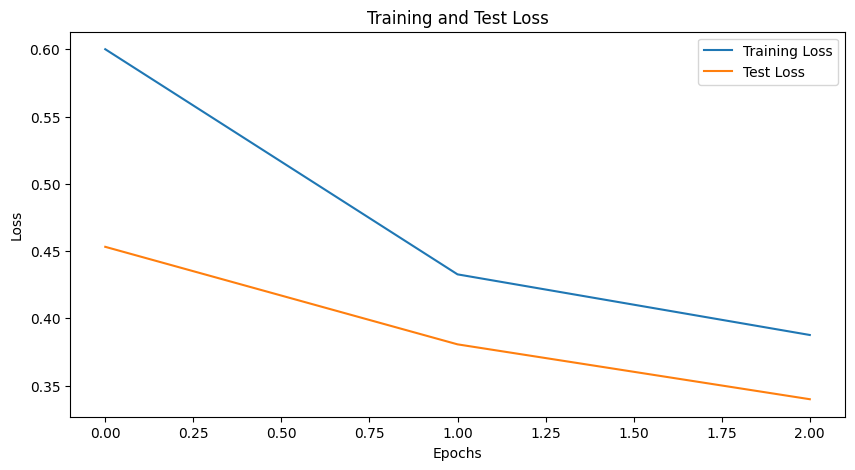

Model saved as 'fashion_mnist_cnn_full.pth'.


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F # Import F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 3
batch_size = 64
learning_rate = 0.01

# Data augmentation and normalization
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load the Fashion-MNIST Dataset
train_dataset = datasets.FashionMNIST(root='./data',
                                      train=True,
                                      transform=transform,
                                      download=True)

test_dataset = datasets.FashionMNIST(root='./data',
                                     train=False,
                                     transform=transforms.Compose([
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5,), (0.5,))
                                     ]),
                                     download=True)

# Data loaders
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

# Define the CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.bn1 = nn.BatchNorm2d(8)  # Batch Normalization
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)  # Batch Normalization
        self.dropout = nn.Dropout(0.25)  # Dropout layer
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)

# Training function
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(train_loader)

# Testing function
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() * data.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n')

    return test_loss, accuracy, all_preds, all_targets

# Training loop with visualization
train_losses = []
test_losses = []
accuracies = []

for epoch in range(1, num_epochs + 1):
    print(f"Epoch {epoch}/{num_epochs}")
    train_loss = train(model, device, train_loader, optimizer, criterion)
    test_loss, accuracy, all_preds, all_targets = test(model, device, test_loader, criterion)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    scheduler.step()

# Classification report
print("\nClassification Report:")
print(classification_report(all_targets, all_preds, target_names=train_dataset.classes))

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

# Save the model
torch.save(model, 'fashion_mnist_cnn_full.pth')
print("Model saved as 'fashion_mnist_cnn_full.pth'.")
